In [38]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import datetime as dt

# Load Dataset

In [39]:
df = pd.read_csv("data.csv", encoding='ISO-8859-1' )

In [40]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Basic Data Exploration

In [41]:
# Check shape
print("Shape:", df.shape)

# Check column info
df.info()

# Describe numerical data
df.describe()

Shape: (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [42]:
#Check Missing and Duplicate Values

# Missing values
missing = df.isnull().sum()
print("Missing values:\n", missing)

Missing values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [43]:
# Check for duplicates
duplicates = df.duplicated().sum()
print("Duplicate rows:", duplicates)

Duplicate rows: 5268


In [44]:
# Count number of canceled orders
canceled_orders = df[df['InvoiceNo'].astype(str).str.startswith('C')]
print("Number of canceled orders:", canceled_orders.shape[0])


Number of canceled orders: 9288


# Data Cleaning

In [45]:
# Drop rows with missing CustomerID
df.dropna(subset=["CustomerID"], inplace=True)


In [46]:
print(df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [47]:
# Remove canceled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [48]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [49]:
# Create TotalPrice = Quantity * UnitPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [50]:
# Filter out negative or zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [51]:
df.shape

(397884, 9)

# Feature Engineering – RFM Metrics

In [52]:
# Snapshot date: 1 day after last invoice
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)


In [53]:

# Group by customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()


In [54]:

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


# Normalize RFM Features 
Notes:
### Why use StandardScaler?
Because it makes all features equally important by putting them on the same scale.

For each value in a column:

Standardized Value=(𝑥−mean) / standard deviation
 
So the resulting data will:

Have mean = 0

Have standard deviation = 1
### Why it’s important (with an example):
Imagine your dataset has:

Recency in days → values like 10, 50, 100

Monetary in dollars → values like 1000, 5000, 20000

If you don’t scale them:

Algorithms like K-Means will think Monetary is more important, just because it's on a larger scale.

That can lead to biased or incorrect clustering.

### When should you use it?
✅ Before K-Means, PCA, SVM, Logistic Regression, etc.

❌ Not needed for tree-based models (like Random Forest, Decision Tree).



In [55]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [56]:
# Note: What’s going on:
#After scaling with StandardScaler, you get:

print(rfm_scaled)

[[ 2.33457414e+00 -4.25096503e-01  8.35866818e+00]
 [-9.05340320e-01  3.54416797e-01  2.50966264e-01]
 [-1.75359593e-01 -3.53398530e-02 -2.85960063e-02]
 ...
 [-8.45341904e-01 -2.95177619e-01 -2.08742313e-01]
 [-8.85340848e-01  1.52368675e+00  4.51854273e-03]
 [-4.95351144e-01 -1.65258736e-01 -2.41412739e-02]]


In [57]:
# But a NumPy array:

# ❌ Has no column names

# ❌ Doesn't support .head() or .describe() directly

# ❌ Isn’t easy to work with like a DataFrame

In [58]:

#So, we convert it to a pandas DataFrame:
#This gives you a clean, labeled, and readable version of your scaled data.


rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
print(rfm_scaled_df.head())



    Recency  Frequency  Monetary
0  2.334574  -0.425097  8.358668
1 -0.905340   0.354417  0.250966
2 -0.175360  -0.035340 -0.028596
3 -0.735345  -0.425097 -0.033012
4  2.174578  -0.425097 -0.191347


In [59]:
# Why specify columns=[...]?
# To give names to the columns that match the original features:

# 'Recency'

# 'Frequency'

# 'Monetary'

# # Without this, your DataFrame would have columns named 0, 1, 2, which is not meaningful.

# Elbow Method for Optimal Clusters
What is the elbow method?
The "elbow" is where the WCSS stops decreasing sharply and starts to flatten.

That point is usually the best number of clusters (k) for your data.

### kmeans.fit(rfm_scaled)
→ This is where the model actually:

Looks at the data (rfm_scaled)

Finds the best cluster centers (centroids)

Assigns each customer to a cluster based on Euclidean distance

Minimizes the inertia_ (which measures how tight the clusters are)

In [60]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)


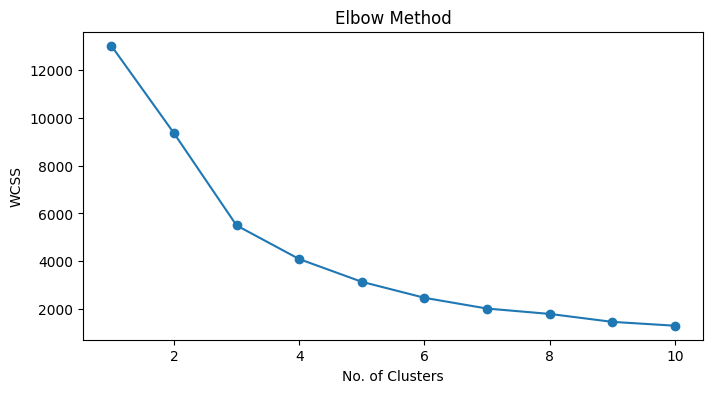

In [61]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS')
plt.show()

# K-Means Clustering

 ### What happens here?
KMeans(n_clusters=4)
→ You're choosing to divide the customers into 4 clusters based on the elbow method.

.fit_predict(rfm_scaled)
→ This does two things:

Fits the model (like .fit())

Predicts the cluster label (0, 1, 2, 3) for each row (customer)

Assigns it to a new column Cluster in the rfm DataFrame
→ Now each customer is labeled with a cluster.

### Silhouette Score
What it tells you:
Silhouette Score measures how well-separated the clusters are.

Value is between -1 and 1:

Closer to 1 → well-clustered (tight and far apart)

Around 0 → overlapping clusters

Below 0 → bad clustering

In [62]:
# Let's assume 4 clusters from elbow curve
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Silhouette Score
score = silhouette_score(rfm_scaled, rfm['Cluster'])
print("Silhouette Score:", score)

Silhouette Score: 0.616212846765192


# Cluster Summary

In [63]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).reset_index()

cluster_summary

,Cluster,Recency,Frequency,Monetary,Count
0,0,43.702685,3.682711,1359.049284,3054
1,1,248.075914,1.552015,480.617480,1067
2,2,7.384615,82.538462,127338.313846,13
3,3,15.500000,22.333333,12709.090490,204


# Visualize Clusters

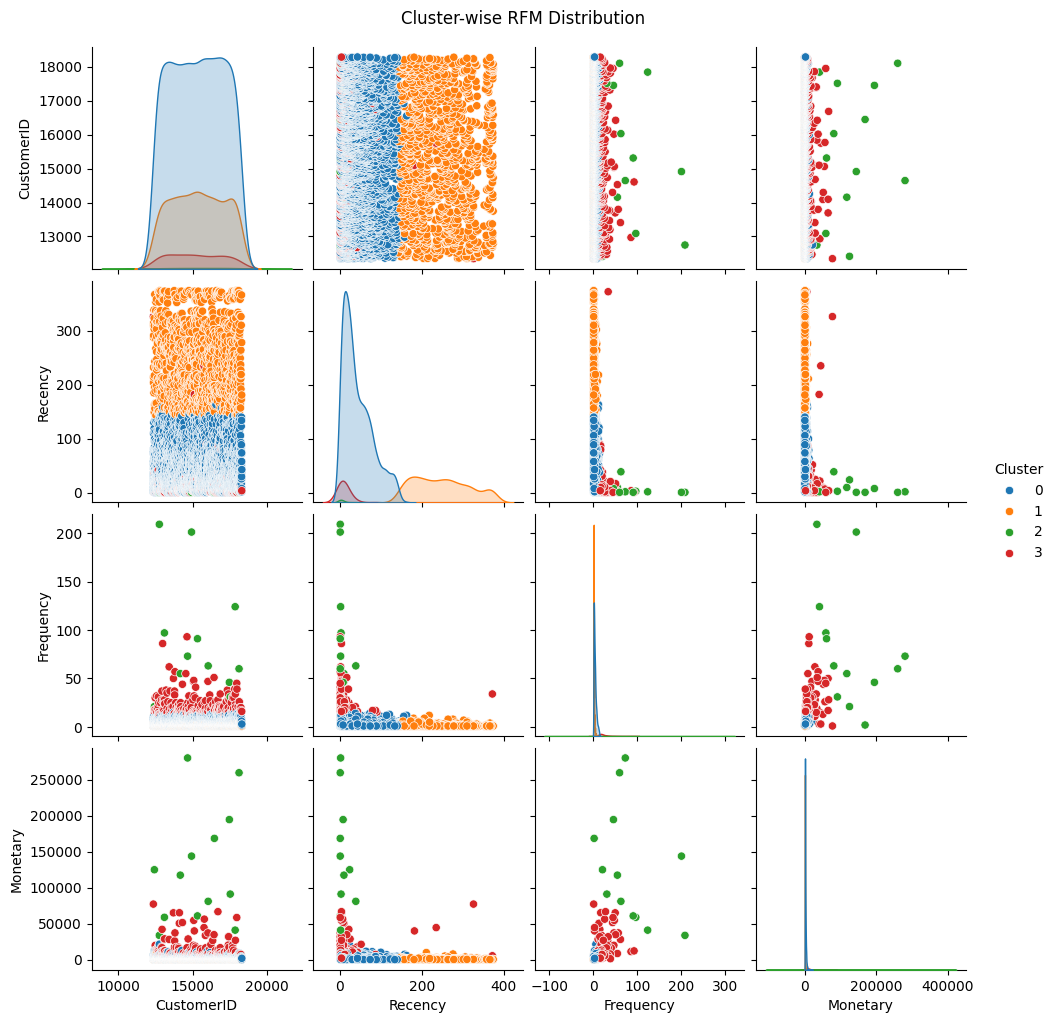

In [64]:
# Pairplot of clusters
sns.pairplot(rfm, hue='Cluster', palette='tab10')
plt.suptitle("Cluster-wise RFM Distribution", y=1.02)
plt.show()

# Save Results

In [65]:
# Export clustered customers to CSV
rfm.to_csv("clustered_customers.csv", index=False)

#  Cluster Summary Table

In [66]:
# Cluster Summary: average RFM per cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Num_Customers'}).round(2)

display(cluster_summary)


,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
0,43.70,3.68,1359.05,3054
1,248.08,1.55,480.62,1067
2,7.38,82.54,127338.31,13
3,15.50,22.33,12709.09,204


# Cluster Characteristics Visualization

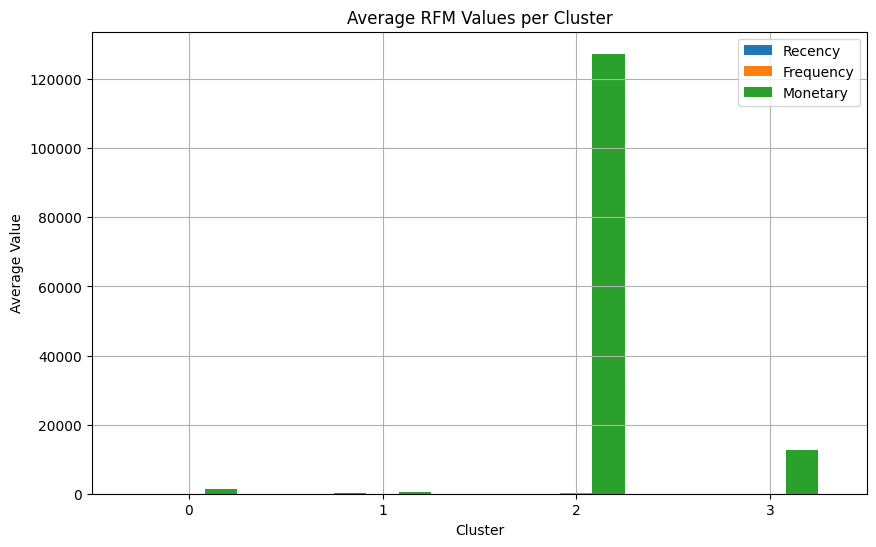

In [67]:
# Bar chart of average RFM values per cluster
import matplotlib.pyplot as plt

cluster_summary[['Recency', 'Frequency', 'Monetary']].plot(kind='bar', figsize=(10,6))
plt.title('Average RFM Values per Cluster')
plt.ylabel('Average Value')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


# Assigning Meaningful Segment Names

In [68]:
# Optional: Rename clusters for business interpretation
cluster_labels = {
    0: 'Best Customers',
    1: 'At-Risk Customers',
    2: 'Loyal Customers',
    3: 'Low-Value Customers'
}
rfm['Segment'] = rfm['Cluster'].map(cluster_labels)

# View a few rows
rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Segment']].head()

,CustomerID,Recency,Frequency,Monetary,Segment
0,12346.0,326,1,77183.60,Low-Value Customers
1,12347.0,2,7,4310.00,Best Customers
2,12348.0,75,4,1797.24,Best Customers
3,12349.0,19,1,1757.55,Best Customers
4,12350.0,310,1,334.40,At-Risk Customers


# Exporting Results for Business Users

In [69]:
# Export the full RFM table with clusters to CSV
rfm.to_csv("csv_rfm_clusters.csv", index=False)

# Optionally, export to Excel
rfm.to_excel("excel_rfm_clusters.xlsx", index=False)


# Optional: Dimensionality Reduction with PCA and t-SNE

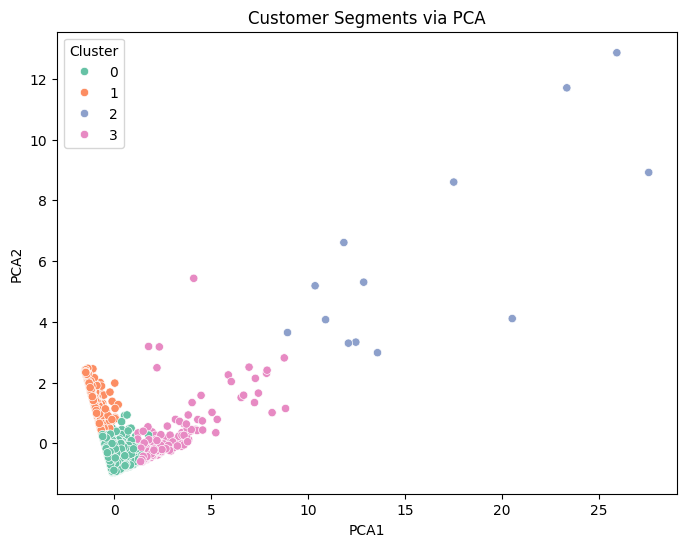

In [70]:
### PCA Visualization

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm, palette='Set2')
plt.title("Customer Segments via PCA")
plt.show()


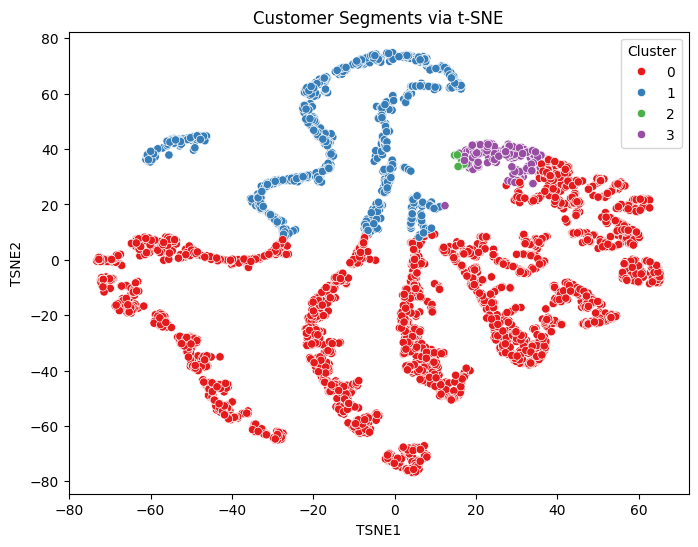

In [71]:
### t-SNE Visualization

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_components = tsne.fit_transform(rfm_scaled)

rfm['TSNE1'] = tsne_components[:, 0]
rfm['TSNE2'] = tsne_components[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=rfm, palette='Set1')
plt.title("Customer Segments via t-SNE")
plt.show()